# 네이버 영화 리뷰 감성분류 모델의 임베딩 분석하기

Main Reference: [LLM-Microscope: Uncovering the Hidden Role of Punctuation in Context Memory of Transformers](https://arxiv.org/abs/2502.15007) (Razzhigaev et al., arXiv 2025)

목표: 현재 임베딩 차원 $d$에 대해 15000개의 단어 집합이 형성되어 있고, 임베딩을 분석.

Sequential model:

    model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_shape=(None,), name="embedding"),
    
    layers.LSTM(32, return_sequences=False),

    
    layers.Dense(16, activation='relu', kernel_regularizer=l2(0.02)),
    layers.Dense(1, activation='sigmoid'),
    ])

### 1. Anisotropy 분석
Reference: [How Contextual are Contextualized Word Representations? Comparing the Geometry of BERT, ELMo, and GPT-2 Embeddings](https://aclanthology.org/D19-1006/) (Ethayarajh, EMNLP-IJCNLP 2019)

Q. 임베딩이 고차원 공간에서 얼마나 비등방적으로 분포해 있는가?

[0,1] 사이의 값이 나오며, 값이 1에 가까울 수록 비등방적인 분포를 뜻함.

직관적으로는, 값이 1에 가깝다면 특정 방향으로 강한 편향이 생길테고, 실질적으로 필요한 차원의 크기가 작을 것으로 기대할 수 있을 듯?
    
Method: 가중치 행렬을 표준정규분포화 한 뒤에, 특이값 분해를 통해 공분산 행렬의 고윳값을 기반으로 비등방성을 추정.

A. 차원이 증가할 수록, 비등방성은 log scale로 감소한다. 임베딩 차원이 크게 할당되면 밑에 서술될 intrinsic dimension이 비례해 증가함에 따라, 가중치는 더 큰 공간에 분포하고 따라서 비등방성은 감소한다.

### 2. Intrinsic Dimension 분석
Reference: [Maximum Likelihood Estimation of Intrinsic Dimension](https://projecteuclid.org/euclid.aos/1132936539) (Levina & Bickel, Annals of Statistics 2005)

Q. 사전에 정의한 임베딩 차원 $d$에 대해, 모델이 학습한 임베딩 가중치는 실제로 얼마의 차원 $d'$ &le; $d$를 갖는가?

생각의 시작점: 주어진 데이터 분포 $\mathcal{D}$에 대하여, 신경망이 학습한 가중치는 정해진 최적의 Intrinsic dimension $d_0$를 갖는가? 구체적으로, 정수 $d_0 > 1$이 있어 $d > d_0$의 임베딩 차원이 할당된 신경망은 내재적 차원을 $d_0$로 갖는가?

Method: Ref에 나온 방법론을 가중치 행렬에 적용.

A. 주어진 임베딩 차원 $d$에 대해, 내재적 차원은 log scale로 비례해 증가하고, 따라서 실제 임베딩 차원과의 비율은 감소한다. 

### Figure: Log scale 경향성

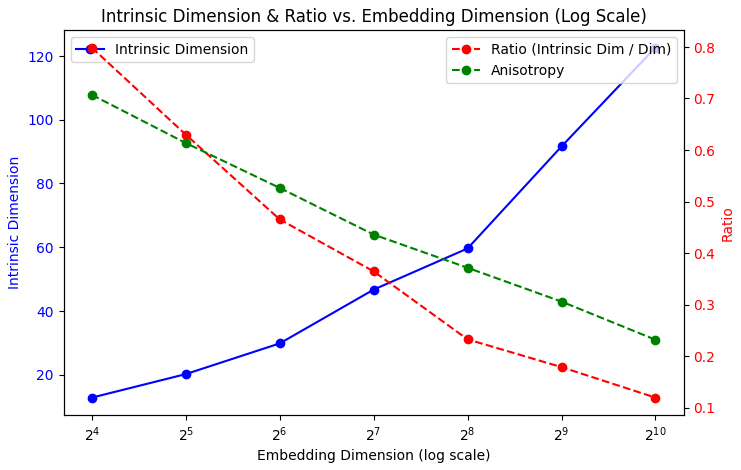

In [153]:
import torch
import numpy as np

torch.set_default_device('cuda:0')

embedding_weights64 = np.load("C:/Users/양자/Desktop/Hun_Works/AIFFEL_quest_rs/GoingDeeper/GD01/embedding_weights_emb64.npy")
embedding_weights128 = np.load("C:/Users/양자/Desktop/Hun_Works/AIFFEL_quest_rs/GoingDeeper/GD01/embedding_weights_emb128.npy")

embedding_weights32 = np.load("C:/Users/양자/Desktop/Hun_Works/AIFFEL_quest_rs/GoingDeeper/GD01/embedding_weights_emb32.npy")
embedding_weights256 = np.load("C:/Users/양자/Desktop/Hun_Works/AIFFEL_quest_rs/GoingDeeper/GD01/embedding_weights_emb256.npy")

embedding_weights16 = np.load("C:/Users/양자/Desktop/Hun_Works/AIFFEL_quest_rs/GoingDeeper/GD01/embedding_weights_emb16.npy")
embedding_weights512 = np.load("C:/Users/양자/Desktop/Hun_Works/AIFFEL_quest_rs/GoingDeeper/GD01/embedding_weights_emb512.npy")

embedding_weights1024 = np.load("C:/Users/양자/Desktop/Hun_Works/AIFFEL_quest_rs/GoingDeeper/GD01/embedding_weights_emb1024.npy")

In [154]:
embedding_tensor64 = torch.tensor(embedding_weights64, dtype=torch.float64)
embedding_tensor128 = torch.tensor(embedding_weights128, dtype=torch.float64)

embedding_tensor32 = torch.tensor(embedding_weights32, dtype=torch.float64)
embedding_tensor256 = torch.tensor(embedding_weights256, dtype=torch.float64)

embedding_tensor16 = torch.tensor(embedding_weights16, dtype=torch.float64)
embedding_tensor512 = torch.tensor(embedding_weights512, dtype=torch.float64)

embedding_tensor1024 = torch.tensor(embedding_weights1024, dtype=torch.float64)

In [156]:
embedding_tensor16 = embedding_tensor16.to('cuda')
embedding_tensor32 = embedding_tensor32.to('cuda')
embedding_tensor64 = embedding_tensor64.to('cuda')
embedding_tensor128 = embedding_tensor128.to('cuda')
embedding_tensor256 = embedding_tensor256.to('cuda')
embedding_tensor512 = embedding_tensor512.to('cuda')
embedding_tensor1024 = embedding_tensor1024.to('cuda')

In [11]:
import math
import random
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

In [107]:
# 임베딩의 비등방성 계산
def calculate_anisotropy_torch(emb):
    embeddings = emb - emb.mean(dim=0, keepdim=True) # sigma=1의 정규화
    U, S, Vh = torch.linalg.svd(embeddings, full_matrices=False)
    cov_einvalues = (S*S) / (embeddings.shape[0] - 1)
    
    anisotropy = float(cov_einvalues.max() / cov_einvalues.sum())
    return anisotropy

In [157]:
anisotropy16 = calculate_anisotropy_torch(embedding_tensor16)
anisotropy32 = calculate_anisotropy_torch(embedding_tensor32)
anisotropy64 = calculate_anisotropy_torch(embedding_tensor64)
anisotropy128 = calculate_anisotropy_torch(embedding_tensor128)
anisotropy256 = calculate_anisotropy_torch(embedding_tensor256)
anisotropy512 = calculate_anisotropy_torch(embedding_tensor512)
anisotropy1024 = calculate_anisotropy_torch(embedding_tensor1024)

print('Anisotropy of 16 embeddings:', anisotropy16)
print('Anisotropy of 32 embeddings:', anisotropy32)
print('Anisotropy of 64 embeddings:', anisotropy64)
print('Anisotropy of 128 embeddings:', anisotropy128)
print('Anisotropy of 256 embeddings:', anisotropy256)
print('Anisotropy of 512 embeddings:', anisotropy512)
print('Anisotropy of 1024 embeddings:', anisotropy1024)

Anisotropy of 16 embeddings: 0.707047451702607
Anisotropy of 32 embeddings: 0.6136632434396923
Anisotropy of 64 embeddings: 0.5265260836884738
Anisotropy of 128 embeddings: 0.4360371247410918
Anisotropy of 256 embeddings: 0.3715744923199004
Anisotropy of 512 embeddings: 0.30600280166022115
Anisotropy of 1024 embeddings: 0.23199077870820486


In [17]:
def intrinsic_dimension(emb, reduction_factor=5):
    with torch.no_grad():
        device = emb.device
        embeddings = emb - emb.mean(dim=0, keepdim=True)
        avg_len = (embeddings * embeddings).sum(dim=1).sqrt().mean()
        embeddings = embeddings / avg_len  # 정규화

        r1 = []
        r2 = []
        n = len(embeddings)
        for i in range(n):
            dsts = torch.nn.functional.pairwise_distance(
                embeddings[i, None, :],
                embeddings[None, :, :],
                eps=0
            )[0]
            dsts = torch.cat([dsts[:i], dsts[i+1:]])
            r1.append(torch.kthvalue(dsts, k=1)[0])  # NN
            r2.append(torch.kthvalue(dsts, k=2)[0])  # 2nd NN

        r1 = torch.tensor(r1, device=device)
        r2 = torch.tensor(r2, device=device)
        
        mu = r2 / r1  # 거리 비율

        mu, _ = torch.sort(mu)
        n = mu.shape[0]
        f_emp = torch.arange(1, n + 1) / n
        num_dots_to_use = min(n // reduction_factor, n - 1)

        mu_log = torch.log(mu)[:num_dots_to_use]
        dist_log = -torch.log(1 - f_emp)[:num_dots_to_use]

        dim = float((mu_log * dist_log).sum() / (mu_log * mu_log).sum())

    return float(dim)

In [25]:
intrinsic_dim64 = intrinsic_dimension(embedding_tensor64)
intrinsic_dim128 = intrinsic_dimension(embedding_tensor128)

Intrinsic Dimension of Embeddings: 29.789208960133504
Intrinsic Dimension of Embeddings: 46.66574848209803


In [37]:
intrinsic_dim32 = intrinsic_dimension(embedding_tensor32)

In [48]:
intrinsic_dim256 = intrinsic_dimension(embedding_tensor256)

In [98]:
intrinsic_dim16 = intrinsic_dimension(embedding_tensor16)

In [146]:
intrinsic_dim512 = intrinsic_dimension(embedding_tensor512)

In [158]:
intrinsic_dim1024 = intrinsic_dimension(embedding_tensor1024)

In [159]:
print("Intrinsic Dimension of 16 Embeddings:", intrinsic_dim16)
print("Intrinsic Dimension of 32 Embeddings:", intrinsic_dim32)
print("Intrinsic Dimension of 64 Embeddings:", intrinsic_dim64)
print("Intrinsic Dimension of 128 Embeddings:", intrinsic_dim128)
print("Intrinsic Dimension of 256 Embeddings:", intrinsic_dim256)
print("Intrinsic Dimension of 512 Embeddings:", intrinsic_dim512)
print("Intrinsic Dimension of 1024 Embeddings:", intrinsic_dim1024)

print("")

print("Ratio of Intrinsic Dim over Dim:", intrinsic_dim16/16)
print("Ratio of Intrinsic Dim over Dim:", intrinsic_dim32/32)
print("Ratio of Intrinsic Dim over Dim:", intrinsic_dim64/64)
print("Ratio of Intrinsic Dim over Dim:", intrinsic_dim128/128)
print("Ratio of Intrinsic Dim over Dim:", intrinsic_dim256/256)
print("Ratio of Intrinsic Dim over Dim:", intrinsic_dim512/512)
print("Ratio of Intrinsic Dim over Dim:", intrinsic_dim1024/1024)

Intrinsic Dimension of 16 Embeddings: 12.779047407139782
Intrinsic Dimension of 32 Embeddings: 20.15590362508529
Intrinsic Dimension of 64 Embeddings: 29.789208960133504
Intrinsic Dimension of 128 Embeddings: 46.66574848209803
Intrinsic Dimension of 256 Embeddings: 59.578441220312506
Intrinsic Dimension of 512 Embeddings: 91.58867110453849
Intrinsic Dimension of 1024 Embeddings: 122.58764942813715

Ratio of Intrinsic Dim over Dim: 0.7986904629462364
Ratio of Intrinsic Dim over Dim: 0.6298719882839153
Ratio of Intrinsic Dim over Dim: 0.465456390002086
Ratio of Intrinsic Dim over Dim: 0.36457616001639087
Ratio of Intrinsic Dim over Dim: 0.23272828601684573
Ratio of Intrinsic Dim over Dim: 0.17888412325105174
Ratio of Intrinsic Dim over Dim: 0.11971450139466519


In [160]:
embedding_dims = np.array([16, 32, 64, 128, 256, 512, 1024])
intrinsic_dims = np.array([intrinsic_dim16, intrinsic_dim32, intrinsic_dim64, intrinsic_dim128, intrinsic_dim256, intrinsic_dim512, intrinsic_dim1024])
anisotropy = np.array([anisotropy16, anisotropy32, anisotropy64, anisotropy128, anisotropy256, anisotropy512, anisotropy1024])
ratios = intrinsic_dims / embedding_dims

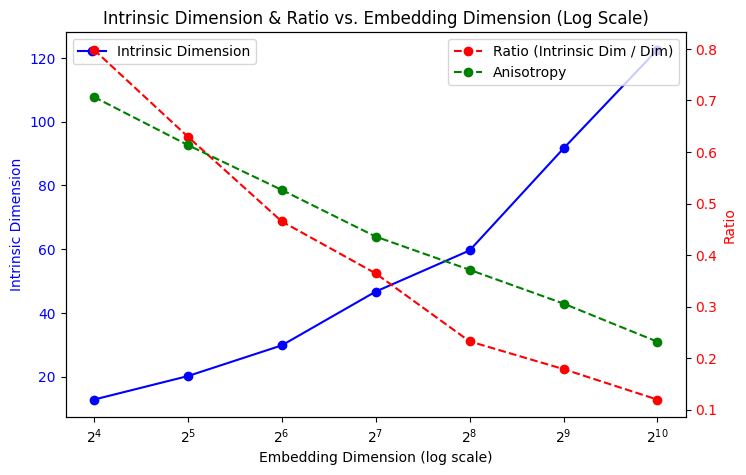

In [161]:
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xscale("log", base=2)

ax1.plot(embedding_dims, intrinsic_dims, 'bo-', label="Intrinsic Dimension")
ax1.set_ylabel("Intrinsic Dimension", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(embedding_dims, ratios, 'ro--', label="Ratio (Intrinsic Dim / Dim)")
ax2.set_ylabel("Ratio", color="red")
ax2.tick_params(axis='y', labelcolor="red")

ax2.plot(embedding_dims, anisotropy, 'go--', label='Anisotropy')

ax1.set_xlabel("Embedding Dimension (log scale)")
plt.title("Intrinsic Dimension & Ratio vs. Embedding Dimension (Log Scale)")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

Best fit parameters: a = 25.8696, b = -70.7852


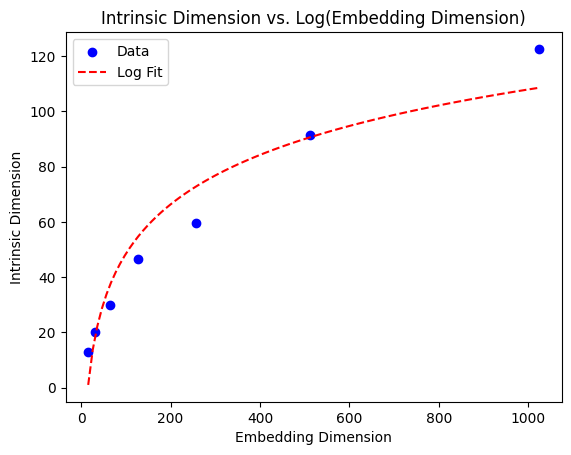

In [164]:
from scipy.optimize import curve_fit

def log_func(x, a, b):
    return a * np.log(x) + b

# 비선형 회귀 피팅
params, covariance = curve_fit(log_func, embedding_dims, intrinsic_dims)

a_fit, b_fit = params
print(f"Best fit parameters: a = {a_fit:.4f}, b = {b_fit:.4f}")

x_fit = np.linspace(16, 1024, 100)
y_fit = log_func(x_fit, *params)

plt.scatter(embedding_dims, intrinsic_dims, color="blue", label="Data")
plt.plot(x_fit, y_fit, color="red", linestyle="--", label="Log Fit")
plt.xlabel("Embedding Dimension")
plt.ylabel("Intrinsic Dimension")
plt.legend()
plt.title("Intrinsic Dimension vs. Log(Embedding Dimension)")
plt.show()


Best fit parameters: a = -0.1634, b = 1.1915


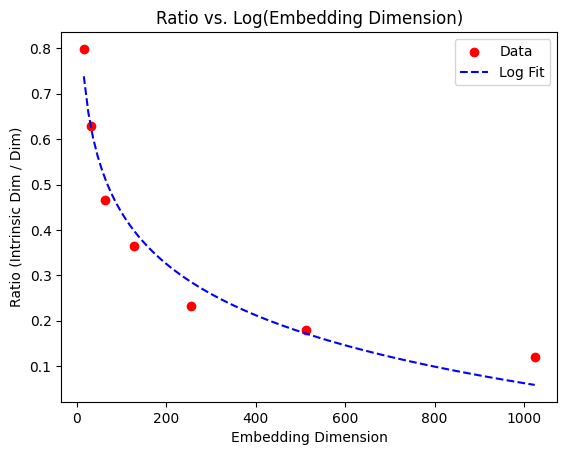

In [165]:
params, covariance = curve_fit(log_func, embedding_dims, ratios)

a_fit, b_fit = params
print(f"Best fit parameters: a = {a_fit:.4f}, b = {b_fit:.4f}")

y_fit = log_func(x_fit, *params)

plt.scatter(embedding_dims, ratios, color="red", label="Data")
plt.plot(x_fit, y_fit, color="blue", linestyle="--", label="Log Fit")
plt.xlabel("Embedding Dimension")
plt.ylabel("Ratio (Intrinsic Dim / Dim)")
plt.legend()
plt.title("Ratio vs. Log(Embedding Dimension)")
plt.show()
